In [1]:
import os
import gc
import csv
import sys
import time
import h5py
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
import nibabel as nib
from nilearn import image, surface, plotting, datasets

from sklearn.metrics import pairwise_distances
import scipy.sparse as sps
import scipy as sp
from scipy.sparse.linalg import eigsh, eigs
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from sklearn.cross_decomposition import PLSCanonical, PLSRegression, CCA
from scipy.stats import pearsonr
import pickle 

/n01dat01/dyli/soft/miniconda3/envs/pynb/lib/python3.8/site-packages/nilearn/datasets/__init__.py:93: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


# read the gene data in fsLR_32k

In [5]:
gene_father = '/n02dat01/users/dyli/Grad_data/support_data/Gene_results'

# read the basic info
dirc_L = '/n02dat01/users/dyli/Atlas/metric_index_L.txt'
select_ind_L = np.loadtxt( dirc_L ).astype(int)
dirc_R = '/n02dat01/users/dyli/Atlas/metric_index_R.txt'
select_ind_R = np.loadtxt( dirc_R ).astype(int)

# read the gene name
gene_name_path = '/n02dat01/users/dyli/Grad_data/support_data/gene_name.txt'
with open( gene_name_path, 'r' ) as f:
    gene_namelist = [ str( line.strip()) for line in f.readlines() ]
assert len(gene_namelist) == 15633

# read the gene expression data, as X data
gene_expression = np.zeros((29696, len(gene_namelist)))
for i, gene in tqdm(enumerate(gene_namelist)):
    gene_ = surface.load_surf_data(f'{gene_father}/GIFTI_L/{gene}.L.func.gii')
    gene_ = gene_[select_ind_L]
    assert gene_.shape[0] == 29696
    gene_expression[:, i] = gene_
np.save(f'{gene_father}/Left_expression', gene_expression)


15633it [05:45, 45.23it/s]


In [3]:
gene_father = '/n02dat01/users/dyli/Grad_data/support_data/Gene_results'
x = np.load(f'{gene_father}/Left_expression.npy')
x

array([[0.37851244, 0.60601878, 0.57522392, ..., 0.64251548, 0.6087153 ,
        0.55850118],
       [0.45830119, 0.63477743, 0.44108373, ..., 0.72542125, 0.53218275,
        0.44150916],
       [0.47783685, 0.53548539, 0.59811842, ..., 0.67867035, 0.30720791,
        0.31622389],
       ...,
       [0.54569924, 0.68947476, 0.49268094, ..., 0.65354198, 0.40816125,
        0.47074497],
       [0.5453102 , 0.6874972 , 0.49219966, ..., 0.65362322, 0.41308492,
        0.47133678],
       [0.57092476, 0.69238484, 0.49327073, ..., 0.61783975, 0.40927759,
        0.49455276]])

# PLSR for gene and gradient: X(29696, 15633), Y(29696,)

In [16]:
gg=2

In [17]:
comp_num = 10

gene_father = '/n02dat01/users/dyli/Grad_data/support_data/Gene_results'

# read the basic info
dirc_L = '/n02dat01/users/dyli/Atlas/metric_index_L.txt'
select_ind_L = np.loadtxt( dirc_L ).astype(int)
dirc_R = '/n02dat01/users/dyli/Atlas/metric_index_R.txt'
select_ind_R = np.loadtxt( dirc_R ).astype(int)

# read the gene name
gene_name_path = '/n02dat01/users/dyli/Grad_data/support_data/gene_name.txt'
with open( gene_name_path, 'r' ) as f:
    gene_namelist = [ str( line.strip()) for line in f.readlines() ]
assert len(gene_namelist) == 15633

# read the gradient data
data_L = np.load('/n02dat01/users/dyli/Grad_data/sc/MPC_Grad_results/MPC_sc_vertex_volume_100_embedding_dense_emb_L_zeros.npy')
y = data_L[:, gg]
x = np.load(f'{gene_father}/Left_expression.npy')

for item in range(10):
    print(item)

    # test data
    x_test = x[item*int(x.shape[0]*0.1):(item+1)*int(x.shape[0]*0.1), :]
    y_test = y[item*int(x.shape[0]*0.1):(item+1)*int(x.shape[0]*0.1)]

    # train data
    x_train = np.delete(x, [ii for ii in range(item*int(x.shape[0]*0.1), (item+1)*int(x.shape[0]*0.1))], axis=0)
    y_train = np.delete(y, [ii for ii in range(item*int(x.shape[0]*0.1), (item+1)*int(x.shape[0]*0.1))], axis=0)

    # PLSR training
    plsr = PLSRegression(n_components=1)
    plsr.fit(x_train, y_train)
    l_fc, l_nmf = plsr.transform(x_train, y_train)

    # PLSR predict
    y_pred = plsr.predict(x_test)

    print(f'the predict results of item:{item}, the comp num = 1: {np.corrcoef(np.squeeze(y_pred), y_test)[0,1]}')

    # save the model parameters
    parameters = {'x_weights_':plsr.x_weights_,
            'y_weights_':plsr.y_weights_,
            'x_loadings_':plsr.x_loadings_,
            'y_loadings_':plsr.y_loadings_,
            'x_rotations_':plsr.x_rotations_,
            'y_rotations_':plsr.y_rotations_,
            'coef_':plsr.coef_}
    # f_save = open(f'/n02dat01/users/dyli/Grad_data/gene_plsr/G{gg+1}/Model/Model_comp{comp}_item{item}_L.pkl', 'wb')
    # pickle.dump(parameters, f_save)
    # f_save.close()

0
the predict results of item:0, the comp num = 1: -0.11223154136339546
1
the predict results of item:1, the comp num = 1: 0.49579203744168265
2
the predict results of item:2, the comp num = 1: 0.3494920177517784
3
the predict results of item:3, the comp num = 1: 0.30821357460881665
4
the predict results of item:4, the comp num = 1: 0.4706496828070416
5
the predict results of item:5, the comp num = 1: 0.6928541271497537
6
the predict results of item:6, the comp num = 1: 0.006530780849963567
7
the predict results of item:7, the comp num = 1: 0.28053527802297856
8
the predict results of item:8, the comp num = 1: 0.2693601156194226
9
the predict results of item:9, the comp num = 1: 0.004237958830921913


: 

In [56]:
# a simple function to quickly load pickle files    
def ldpkl(filename: str): 
    with open(filename, 'rb') as f:
        return pickle.load(f)
    
# find the best plsr
for item in range(10):
    print(item)
    model_path = f'/n02dat01/users/dyli/Grad_data/gene_plsr/G{gg+1}/Model'
    model = ldpkl(f'{model_path}/Model_comp1_item{item}_L.pkl')

    y_weights_ = model['y_weights_']
    x_weights_ = model['x_weights_']
    print(f'the weight of Y: {y_weights_.shape}, the weight of X: {x_weights_.shape}')

    x_comp = np.dot(x, x_weights_)
    print(np.corrcoef(x_comp[:,0], y)[0,1])

0
the weight of Y: (1, 2), the weight of X: (15633, 2)
0.21923803368185452
1
the weight of Y: (1, 2), the weight of X: (15633, 2)
0.18769891922241186
2
the weight of Y: (1, 2), the weight of X: (15633, 2)
0.1958371741767072
3
the weight of Y: (1, 2), the weight of X: (15633, 2)
0.18742547028695836
4
the weight of Y: (1, 2), the weight of X: (15633, 2)
0.20077750236366
5
the weight of Y: (1, 2), the weight of X: (15633, 2)
0.18673233052677712
6
the weight of Y: (1, 2), the weight of X: (15633, 2)
0.1921503577187075
7
the weight of Y: (1, 2), the weight of X: (15633, 2)
0.19341557425463615
8
the weight of Y: (1, 2), the weight of X: (15633, 2)
0.17462965419674115
9
the weight of Y: (1, 2), the weight of X: (15633, 2)
0.1776146226928446


In [9]:
# a simple function to quickly load pickle files    
def ldpkl(filename: str): 
    with open(filename, 'rb') as f:
        return pickle.load(f)

# read the gene name
gene_name_path = '/n02dat01/users/dyli/Grad_data/support_data/gene_name.txt'
with open( gene_name_path, 'r' ) as f:
    gene_namelist = [ str( line.strip()) for line in f.readlines() ]
assert len(gene_namelist) == 15633

# read the basic info
dirc_L = '/n02dat01/users/dyli/Atlas/metric_index_L.txt'
select_ind_L = np.loadtxt( dirc_L ).astype(int)
dirc_R = '/n02dat01/users/dyli/Atlas/metric_index_R.txt'
select_ind_R = np.loadtxt( dirc_R ).astype(int)
    
# read the top gene expression
for gg in range(3):
    if gg == 0: item=8
    elif gg == 1: item=0
    elif gg == 2: item=9
    
    model_path = f'/n02dat01/users/dyli/Grad_data/gene_plsr/G{gg+1}/Model'
    if gg == 0:
        model = ldpkl(f'{model_path}/Model_comp1_iten{item}_L.pkl')
    else:
        model = ldpkl(f'{model_path}/Model_comp1_item{item}_L.pkl')

    y_weights_ = model['y_weights_']
    x_weights_ = model['x_weights_']
    print(f'the weight of Y: {y_weights_.shape}, the weight of X: {x_weights_.shape}')

    x_weights_abs = np.abs(x_weights_[:, 0])
    x_weights_abs_idx = np.argsort(x_weights_abs)[::-1]
    x_weights_abs_sort = x_weights_abs[x_weights_abs_idx]

    # find the top gene
    for gene_save_num in [1000, int(15633/10)]:
        gene_save_list = [gene_namelist[x_weights_abs_idx[i]] for i in range(gene_save_num)]
        gene_save = np.zeros((gene_save_num, 29696))
        for i in tqdm(range(gene_save_num)):
            gene_ = surface.load_surf_data(f'{gene_father}/GIFTI_L/{gene_save_list[i]}.L.func.gii')
            gene_ = gene_[select_ind_L]
            assert gene_.shape[0] == 29696

            gene_save[i, :] = gene_
        np.save(f'/n02dat01/users/dyli/Grad_data/gene_plsr/G{gg+1}/comp0_item{item}_top{gene_save_num}', gene_save)

the weight of Y: (1, 2), the weight of X: (15633, 2)


100%|██████████| 1563/1563 [00:17<00:00, 91.69it/s] 


the weight of Y: (1, 2), the weight of X: (15633, 2)


100%|██████████| 1563/1563 [00:16<00:00, 96.05it/s] 


the weight of Y: (1, 2), the weight of X: (15633, 2)


100%|██████████| 1563/1563 [00:14<00:00, 107.07it/s]


In [15]:
# a simple function to quickly load pickle files    
def ldpkl(filename: str): 
    with open(filename, 'rb') as f:
        return pickle.load(f)
    
# read the gene name
gene_name_path = '/n02dat01/users/dyli/Grad_data/support_data/gene_name.txt'
with open( gene_name_path, 'r' ) as f:
    gene_namelist = [ str( line.strip()) for line in f.readlines() ]
assert len(gene_namelist) == 15633
    
gg=0

# read the expression in ROIs
for roi_num in [10, 20, 50, 100]:
    if gg == 0: item=8
    elif gg == 1: item=0
    elif gg == 2: item=9

    model_path = f'/n02dat01/users/dyli/Grad_data/gene_plsr/G{gg+1}/Model'
    if gg ==0: model = ldpkl(f'{model_path}/Model_comp1_iten{item}_L.pkl')
    else: model = ldpkl(f'{model_path}/Model_comp1_item{item}_L.pkl')

    y_weights_ = model['y_weights_']
    x_weights_ = model['x_weights_']
    print(f'the weight of Y: {y_weights_.shape}, the weight of X: {x_weights_.shape}')

    x_weights_abs = np.abs(x_weights_[:, 0])
    x_weights_abs_idx = np.argsort(x_weights_abs)[::-1]
    x_weights_abs_sort = x_weights_abs[x_weights_abs_idx]

    for gene_save_num in [1000, int(15633/10)]:

        gene_save_list = [gene_namelist[x_weights_abs_idx[i]] for i in range(gene_save_num)]

        # read the gradient data
        data_L = np.load('/n02dat01/users/dyli/Grad_data/sc/MPC_Grad_results/MPC_sc_vertex_volume_100_embedding_dense_emb_L_zeros.npy')

        # read the gene data
        gene_exp_L = np.load(f'/n02dat01/users/dyli/Grad_data/gene_plsr/G{gg+1}/comp0_item{item}_top{gene_save_num}.npy') # (1000, 29696)

        gene_exp_inROI = np.zeros((gene_save_num, roi_num))
        data_L_gg = np.squeeze(data_L[:, gg]) # (29696, )
        data_L_gg_idx = np.argsort(data_L_gg)[::-1]

        for roii in range(roi_num):
            gene_exp_ = gene_exp_L[:, data_L_gg_idx[roii*(int(29696/roi_num)) : (roii+1)*(int(29696/roi_num))]] # (1000, 2969)
            gene_exp_inROI[:, roii] = np.mean(gene_exp_, axis=1)

        np.savetxt(f'/n02dat01/users/dyli/Grad_data/gene_plsr/G{gg+1}/comp0_item{item}_top{gene_save_num}_roinum{roi_num}_G{gg+1}.txt', gene_exp_inROI)
        df = pd.DataFrame(gene_exp_inROI.T, columns=gene_save_list, index = [f'ROI{ii}' for ii in range(roi_num)])
        df.to_csv(f'/n02dat01/users/dyli/Grad_data/gene_plsr/G{gg+1}/comp0_item{item}_top{gene_save_num}_roinum{roi_num}_G{gg+1}.csv')

the weight of Y: (1, 2), the weight of X: (15633, 2)
the weight of Y: (1, 2), the weight of X: (15633, 2)
the weight of Y: (1, 2), the weight of X: (15633, 2)
the weight of Y: (1, 2), the weight of X: (15633, 2)


# permution for weight

In [45]:
gg=2

### find the best comp for each gradient

In [31]:
comp_num = 10

gene_father = '/n02dat01/users/dyli/Grad_data/support_data/Gene_results'

# read the basic info
dirc_L = '/n02dat01/users/dyli/Atlas/metric_index_L.txt'
select_ind_L = np.loadtxt( dirc_L ).astype(int)
dirc_R = '/n02dat01/users/dyli/Atlas/metric_index_R.txt'
select_ind_R = np.loadtxt( dirc_R ).astype(int)

# read the gene name
gene_name_path = '/n02dat01/users/dyli/Grad_data/support_data/gene_name.txt'
with open( gene_name_path, 'r' ) as f:
    gene_namelist = [ str( line.strip()) for line in f.readlines() ]
assert len(gene_namelist) == 15633
# read the gradient data
data_L = np.load('/n02dat01/users/dyli/Grad_data/sc/MPC_Grad_results/MPC_sc_vertex_volume_100_embedding_dense_emb_L_zeros.npy')
y = data_L[:, gg]
x = np.load(f'{gene_father}/Left_expression.npy')
# print(x.shape, y.shape)

# data = np.concatenate((x,y[:,np.newaxis]), axis=1)
# print(data.shape)

for item in range(10):
    for comp in range(1,comp_num):
        # test data
        x_test = x[item*int(x.shape[0]*0.1):(item+1)*int(x.shape[0]*0.1), :]
        y_test = y[item*int(x.shape[0]*0.1):(item+1)*int(x.shape[0]*0.1)]

        # train data
        x_train = np.delete(x, [ii for ii in range(item*int(x.shape[0]*0.1), (item+1)*int(x.shape[0]*0.1))], axis=0)
        y_train = np.delete(y, [ii for ii in range(item*int(x.shape[0]*0.1), (item+1)*int(x.shape[0]*0.1))], axis=0)

        # PLSR training
        plsr = PLSRegression(n_components=comp)
        plsr.fit(x_train, y_train)
        l_fc, l_nmf = plsr.transform(x_train, y_train)

        # PLSR predict
        y_pred = plsr.predict(x_test)

        # the pearson correlation
        print(f'the predict results of item:{item}, the comp num = {comp}: {np.corrcoef(np.squeeze(y_pred), y_test)[0,1]}')

        # save the model parameters
        parameters = {'x_weights_':plsr.x_weights_,
                'y_weights_':plsr.y_weights_,
                'x_loadings_':plsr.x_loadings_,
                'y_loadings_':plsr.y_loadings_,
                'x_rotations_':plsr.x_rotations_,
                'y_rotations_':plsr.y_rotations_,
                'coef_':plsr.coef_,
                'y_pred':np.squeeze(y_pred),
                'y_true':y_test}
        f_save = open(f'/n02dat01/users/dyli/Grad_data/gene_plsr/G{gg+1}/Model/Model_comp{comp}_item{item}_L.pkl', 'wb')
        pickle.dump(parameters, f_save)
        f_save.close()

the predict results of item:0, the comp num = 1: 0.6451292108368846
the predict results of item:0, the comp num = 2: 0.6451292108368846
the predict results of item:0, the comp num = 3: 0.6451292108368846


In [46]:
gene_father = '/n02dat01/users/dyli/Grad_data/support_data/Gene_results'

# read the basic info
dirc_L = '/n02dat01/users/dyli/Atlas/metric_index_L.txt'
select_ind_L = np.loadtxt( dirc_L ).astype(int)
dirc_R = '/n02dat01/users/dyli/Atlas/metric_index_R.txt'
select_ind_R = np.loadtxt( dirc_R ).astype(int)

# read the gene name
gene_name_path = '/n02dat01/users/dyli/Grad_data/support_data/gene_name.txt'
with open( gene_name_path, 'r' ) as f:
    gene_namelist = [ str( line.strip()) for line in f.readlines() ]
assert len(gene_namelist) == 15633
# read the gradient data
data_L = np.load('/n02dat01/users/dyli/Grad_data/sc/MPC_Grad_results/MPC_sc_vertex_volume_100_embedding_dense_emb_L_zeros.npy')
y = data_L[:, gg]
x = np.load(f'{gene_father}/Left_expression.npy')
# print(x.shape, y.shape)

data = np.concatenate((x,y[:,np.newaxis]), axis=1)
# print(data.shape)

if gg == 0: item=0
elif gg == 1: item=1
elif gg == 2: item=5

for part in range(1,11):
    for pp in range(100):
        if not os.path.exists(f'/n02dat01/users/dyli/Grad_data/gene_plsr/G{gg+1}/Model/Model_Bootstrap_part{part}_{pp}_comp1_item{item}_L.pkl'):
            print(part, pp)
            # b = np.random.choice(29696, 29696)
            # data_b = np.zeros(data.shape)
            # for ii in range(29696):
            #     data_b[ii,:] = data[int(b[ii]),:]
            # data_b = data_b.astype(np.float32)

            # x = data_b[:, 0:-1]
            # y = np.squeeze(data_b[:, -1])

            # # test data
            # x_test = x[item*int(x.shape[0]*0.1):(item+1)*int(x.shape[0]*0.1), :].astype(np.float32)
            # y_test = y[item*int(x.shape[0]*0.1):(item+1)*int(x.shape[0]*0.1)].astype(np.float32)

            # # train data
            # x_train = np.delete(x, [ii for ii in range(item*int(x.shape[0]*0.1), (item+1)*int(x.shape[0]*0.1))], axis=0).astype(np.float32)
            # y_train = np.delete(y, [ii for ii in range(item*int(x.shape[0]*0.1), (item+1)*int(x.shape[0]*0.1))], axis=0).astype(np.float32)

            # # PLSR training
            # plsr = PLSRegression(n_components=2)
            # plsr.fit(x_train, y_train)
            # l_fc, l_nmf = plsr.transform(x_train, y_train)

            # # PLSR predict
            # y_pred = plsr.predict(x_test)

            # # the pearson correlation
            # print(f'the predict results of item:{item}, the comp num = 1: {np.corrcoef(np.squeeze(y_pred), y_test)[0,1]}')

            # # save the model parameters
            # parameters = {'x_weights_':plsr.x_weights_,
            #         'y_weights_':plsr.y_weights_,
            #         'x_loadings_':plsr.x_loadings_,
            #         'y_loadings_':plsr.y_loadings_,
            #         'x_rotations_':plsr.x_rotations_,
            #         'y_rotations_':plsr.y_rotations_,
            #         'coef_':plsr.coef_,
            #         'y_pred':np.squeeze(y_pred),
            #         'y_true':y_test}
            # f_save = open(f'/n02dat01/users/dyli/Grad_data/gene_plsr/G{gg+1}/Model/Model_Bootstrap_part{part}_{pp}_comp1_item{item}_L.pkl', 'wb')
            # pickle.dump(parameters, f_save)
            # f_save.close()

In [47]:
# a simple function to quickly load pickle files    
def ldpkl(filename: str): 
    with open(filename, 'rb') as f:
        return pickle.load(f)
    
# read the gene name
gene_name_path = '/n02dat01/users/dyli/Grad_data/support_data/gene_name.txt'
with open( gene_name_path, 'r' ) as f:
    gene_namelist = [ str( line.strip()) for line in f.readlines() ]
assert len(gene_namelist) == 15633

if gg == 0: item=0
elif gg == 1: item=1
elif gg == 2: item=5

bootstrap_re = np.zeros((1000, 15633))
for part in range(1,11):
    for pp in range(100):

        model = ldpkl(f'/n02dat01/users/dyli/Grad_data/gene_plsr/G{gg+1}/Model/Model_Bootstrap_part{part}_{pp}_comp1_item{item}_L.pkl')

        x_weights_ = model['x_weights_']
        bootstrap_re[int((part-1)*100+pp), :] = x_weights_[:,0]

model = ldpkl(f'/n02dat01/users/dyli/Grad_data/gene_plsr/G{gg+1}/Model/Model_comp2_item{item}_L.pkl')
true_weight = model['x_weights_'][:,0]
std = np.std(bootstrap_re, axis=0)
z = true_weight / std
np.savetxt(f'/n02dat01/users/dyli/Grad_data/gene_plsr/G{gg+1}/z_comp2_item{item}_L.txt', z)

# save the results
df = pd.DataFrame(bootstrap_re, columns=gene_namelist, index = [f'G{gg+1}_{ii+1}' for ii in range(1000)])
df.loc[len(df)] = true_weight
df.loc[len(df)] = std
df.loc[len(df)] = z
df.to_csv(f'/n02dat01/users/dyli/Grad_data/gene_plsr/G{gg+1}/comp0_item{item}_bootstrap1000_G{gg+1}.csv')

In [48]:
df

,A1BG,A1BG-AS1,A2M,A2ML1,A3GALT2,A4GALT,AAAS,AACS,AADACL3,AADAT,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
G3_1,0.016791,0.011887,-0.002568,-0.006980,-0.000572,0.010255,-0.006439,-0.001817,-0.007577,0.000247,...,-0.002379,0.020984,0.011007,-0.003662,-0.000823,-0.001943,0.004046,-0.005523,-0.012955,0.012186
G3_2,0.016615,0.012252,-0.002904,-0.006308,-0.000026,0.009491,-0.006292,-0.002000,-0.007935,0.000988,...,-0.002336,0.020399,0.011082,-0.002581,0.000004,-0.001123,0.004493,-0.005879,-0.012001,0.013424
G3_3,0.016855,0.012043,-0.002651,-0.005991,0.000070,0.009839,-0.006749,-0.001443,-0.007164,0.000848,...,-0.001971,0.020398,0.011358,-0.003300,0.000401,-0.001589,0.004639,-0.005959,-0.013007,0.012547
G3_4,0.017031,0.011780,-0.002789,-0.007111,-0.000496,0.009634,-0.006225,-0.001807,-0.008288,0.000429,...,-0.002495,0.021451,0.011166,-0.002752,-0.000415,-0.001792,0.003853,-0.005779,-0.012865,0.013014
G3_5,0.016190,0.012109,-0.002239,-0.005772,-0.001153,0.009888,-0.006401,-0.001294,-0.008218,0.001804,...,-0.002399,0.020340,0.011129,-0.003469,0.000010,-0.002157,0.004703,-0.005336,-0.012630,0.012383
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
G3_999,0.016716,0.012243,-0.003068,-0.005984,0.000240,0.009409,-0.006117,-0.001861,-0.007382,0.000547,...,-0.002397,0.020801,0.011443,-0.002733,-0.000019,-0.001409,0.004691,-0.006047,-0.012606,0.012508
G3_1000,0.016309,0.011684,-0.002486,-0.006332,0.000289,0.010909,-0.006797,-0.001925,-0.007584,-0.000140,...,-0.002772,0.020693,0.010380,-0.002941,-0.000598,-0.001811,0.004142,-0.005655,-0.013376,0.012201
1000,0.017460,0.011265,-0.004635,-0.004283,-0.000362,0.009925,-0.007715,-0.003957,-0.008474,0.000287,...,-0.005495,0.019277,0.010717,-0.000780,-0.000286,-0.000102,0.002242,-0.007590,-0.013011,0.013251
1001,0.000286,0.000309,0.000368,0.000377,0.000397,0.000414,0.000364,0.000386,0.000360,0.000371,...,0.000368,0.000350,0.000349,0.000361,0.000401,0.000354,0.000354,0.000377,0.000300,0.000311


6406


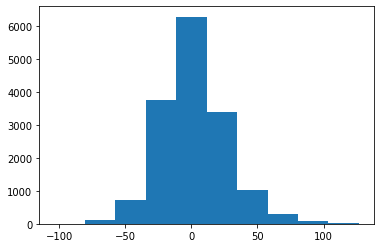

In [49]:
# p = np.loadtxt(f'/n02dat01/users/dyli/Grad_data/gene_plsr/G{gg+1}/p_comp2_item{item}_L.txt')
print(len(np.argwhere(z>5)))
plt.hist(z)
plt.show()

* calulate the plsr to predient gradient from genetic expression
* Author: Morgan
* Ref:    https://www.pnas.org/doi/full/10.1073/pnas.1820754116
* Link:   https://github.com/SarahMorgan/Morphometric_Similarity_SZ/blob/master/Gene_analyses.md

In [53]:
gene_father = '/n02dat01/users/dyli/Grad_data/support_data/Gene_results'

# read the basic info
dirc_L = '/n02dat01/users/dyli/Atlas/metric_index_L.txt'
select_ind_L = np.loadtxt( dirc_L ).astype(int)
dirc_R = '/n02dat01/users/dyli/Atlas/metric_index_R.txt'
select_ind_R = np.loadtxt( dirc_R ).astype(int)

# read the gene name
gene_name_path = '/n02dat01/users/dyli/Grad_data/support_data/gene_name.txt'
with open( gene_name_path, 'r' ) as f:
    gene_namelist = [ str( line.strip()) for line in f.readlines() ]
assert len(gene_namelist) == 15633

z_thr = 5

ind_all_pnas = []
ind_all_my = []
for gg in range(3):
    print(f'the results of global connectopy GC{gg+1}:')
    ind1= np.loadtxt(f'{gene_father}/ind1_G{gg+1}.txt')
    z1  = np.loadtxt(f'{gene_father}/Z1_G{gg+1}.txt')
    z2  = np.loadtxt(f'{gene_father}/Z2_G{gg+1}.txt')
    p1  = np.loadtxt(f'{gene_father}/p1_G{gg+1}.txt')
    p2  = np.loadtxt(f'{gene_father}/p2_G{gg+1}.txt')
    print(f'PNAS: {len(np.argwhere(z1>z_thr))+len(np.argwhere(z1<-1*z_thr))}')

    if gg == 0: item=0
    elif gg == 1: item=1
    elif gg == 2: item=5
    df  = pd.read_csv(f'/n02dat01/users/dyli/Grad_data/gene_plsr/G{gg+1}/comp0_item{item}_bootstrap1000_G{gg+1}.csv')
    ind = np.array([i+1 for i in range(15633)]).astype(np.int32)
    z   = np.array(list(df.loc[df.index[-1]])).astype(np.float32)[1:]
    print(f'my:   {len(np.argwhere(z>z_thr))+len(np.argwhere(z<-1*z_thr))}')

    # choose PNAS results
    ind_temp = list(np.squeeze(ind1[np.argwhere(z1>z_thr)]).astype(np.int32))
    if len(ind_all_pnas) ==0: ind_all_pnas = ind_temp
    # else: ind_all_pnas = list(set(ind_all_pnas).union(set(ind_temp)))
    else: ind_all_pnas = list(set(ind_all_pnas).intersection(set(ind_temp)))

    # choose my results
    ind_temp = list(np.squeeze(ind[np.argwhere(z>z_thr)]).astype(np.int32))
    if len(ind_all_my) ==0: ind_all_my = ind_temp
    # else: ind_all_my = list(set(ind_all_my).union(set(ind_temp)))
    else: ind_all_my = list(set(ind_all_my).intersection(set(ind_temp)))
print(len(ind_all_pnas))
print(len(ind_all_my))

gene_save_list = [gene_namelist[int(ind_all_my[ii]-1)] for ii in range(len(ind_all_my))]
gene_exp_array = np.zeros((29696, len(gene_save_list)))
for gene_i, gene in enumerate(gene_save_list):
    gene_ = surface.load_surf_data(f'{gene_father}/GIFTI_L/{gene}.L.func.gii')
    gene_ = gene_[select_ind_L]
    assert gene_.shape[0] == 29696
    gene_exp_array[:, gene_i] = gene_
gene_exp_df = pd.DataFrame(gene_exp_array, columns=gene_save_list, index = [i for i in range(29696)])
gene_exp_df.to_csv(f'/n02dat01/users/dyli/Grad_data/gene_plsr/ThreeGC_Z{z_thr}_pos.csv')

the results of global connectopy GC1:
PNAS: 13741
my:   13643
the results of global connectopy GC2:
PNAS: 13902
my:   13811
the results of global connectopy GC3:
PNAS: 12960
my:   12866
6738
2545


In [54]:
gene_exp_df

,A1BG-AS1,MRPL52,MRPL53,MRPL54,MRPL57,AAMDC,MRPS14,MRPS16,MRPS18A,MRPS18C,...,MRPL18,MRPL20,MRPL23,MRPL24,MRPL28,MRPL3,MRPL30,MRPL36,MRPL37,MRPL41
0,0.606019,0.324615,0.638656,0.411343,0.420800,0.461291,0.527600,0.428264,0.588802,0.570349,...,0.643392,0.462299,0.368474,0.510706,0.579125,0.502107,0.581398,0.532900,0.419179,0.652748
1,0.634777,0.317768,0.699079,0.582453,0.539204,0.621399,0.579596,0.547757,0.690862,0.730640,...,0.641562,0.407977,0.341707,0.706008,0.526351,0.449588,0.626506,0.579549,0.474389,0.565136
2,0.535485,0.435637,0.759850,0.659085,0.543962,0.507499,0.719151,0.599720,0.756536,0.872677,...,0.760504,0.658806,0.465970,0.574687,0.689375,0.583750,0.731581,0.748291,0.553201,0.468136
3,0.702430,0.367753,0.433459,0.406330,0.391025,0.377818,0.407297,0.397499,0.591492,0.669284,...,0.505498,0.428540,0.331104,0.477734,0.591681,0.613759,0.630210,0.465678,0.634848,0.461907
4,0.664545,0.497375,0.612499,0.676613,0.574191,0.364765,0.534282,0.322669,0.676720,0.597816,...,0.597766,0.452877,0.448052,0.499572,0.670266,0.616827,0.633683,0.542734,0.483600,0.649305
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29691,0.701339,0.425726,0.521561,0.586076,0.496243,0.438131,0.450703,0.455546,0.670045,0.654390,...,0.629502,0.485204,0.430750,0.464327,0.706406,0.556791,0.670228,0.550751,0.512436,0.595341
29692,0.706924,0.421340,0.515219,0.601547,0.500293,0.416783,0.451932,0.451909,0.672299,0.651682,...,0.640603,0.479660,0.423559,0.462043,0.712589,0.554888,0.673164,0.531970,0.512253,0.593576
29693,0.689475,0.437093,0.579976,0.580145,0.526836,0.492336,0.498903,0.479216,0.676058,0.653028,...,0.643737,0.491087,0.430401,0.496508,0.710547,0.576360,0.669379,0.593487,0.497655,0.597720
29694,0.687497,0.439821,0.576749,0.584953,0.529251,0.485459,0.502806,0.475912,0.677474,0.645612,...,0.647841,0.488391,0.424426,0.498707,0.710999,0.573370,0.674589,0.589582,0.493982,0.597183


In [55]:
gene_father = '/n02dat01/users/dyli/Grad_data/support_data/Gene_results'

# read the basic info
dirc_L = '/n02dat01/users/dyli/Atlas/metric_index_L.txt'
select_ind_L = np.loadtxt( dirc_L ).astype(int)
dirc_R = '/n02dat01/users/dyli/Atlas/metric_index_R.txt'
select_ind_R = np.loadtxt( dirc_R ).astype(int)

# read the gene name
gene_name_path = '/n02dat01/users/dyli/Grad_data/support_data/gene_name.txt'
with open( gene_name_path, 'r' ) as f:
    gene_namelist = [ str( line.strip()) for line in f.readlines() ]
assert len(gene_namelist) == 15633

z_thr = -5

ind_all_pnas = []
ind_all_my = []
for gg in range(3):
    print(f'the results of global connectopy GC{gg+1}:')
    ind1= np.loadtxt(f'{gene_father}/ind1_G{gg+1}.txt')
    z1  = np.loadtxt(f'{gene_father}/Z1_G{gg+1}.txt')
    z2  = np.loadtxt(f'{gene_father}/Z2_G{gg+1}.txt')
    p1  = np.loadtxt(f'{gene_father}/p1_G{gg+1}.txt')
    p2  = np.loadtxt(f'{gene_father}/p2_G{gg+1}.txt')
    print(f'PNAS: {len(np.argwhere(z1>z_thr))+len(np.argwhere(z1<-1*z_thr))}')

    if gg == 0: item=0
    elif gg == 1: item=1
    elif gg == 2: item=5
    df  = pd.read_csv(f'/n02dat01/users/dyli/Grad_data/gene_plsr/G{gg+1}/comp0_item{item}_bootstrap1000_G{gg+1}.csv')
    ind = np.array([i+1 for i in range(15633)]).astype(np.int32)
    z   = np.array(list(df.loc[df.index[-1]])).astype(np.float32)[1:]
    print(f'my:   {len(np.argwhere(z>z_thr))+len(np.argwhere(z<-1*z_thr))}')

    # choose PNAS results
    ind_temp = list(np.squeeze(ind1[np.argwhere(z1<z_thr)]).astype(np.int32))
    if len(ind_all_pnas) ==0: ind_all_pnas = ind_temp
    # else: ind_all_pnas = list(set(ind_all_pnas).union(set(ind_temp)))
    else: ind_all_pnas = list(set(ind_all_pnas).intersection(set(ind_temp)))

    # choose my results
    ind_temp = list(np.squeeze(ind[np.argwhere(z<z_thr)]).astype(np.int32))
    if len(ind_all_my) ==0: ind_all_my = ind_temp
    # else: ind_all_my = list(set(ind_all_my).union(set(ind_temp)))
    else: ind_all_my = list(set(ind_all_my).intersection(set(ind_temp)))
print(len(ind_all_pnas))
print(len(ind_all_my))

gene_save_list = [gene_namelist[int(ind_all_my[ii]-1)] for ii in range(len(ind_all_my))]
gene_exp_array = np.zeros((29696, len(gene_save_list)))
for gene_i, gene in enumerate(gene_save_list):
    gene_ = surface.load_surf_data(f'{gene_father}/GIFTI_L/{gene}.L.func.gii')
    gene_ = gene_[select_ind_L]
    assert gene_.shape[0] == 29696
    gene_exp_array[:, gene_i] = gene_
gene_exp_df = pd.DataFrame(gene_exp_array, columns=gene_save_list, index = [i for i in range(29696)])
gene_exp_df.to_csv(f'/n02dat01/users/dyli/Grad_data/gene_plsr/ThreeGC_Z{z_thr}_neg.csv')

the results of global connectopy GC1:
PNAS: 17525
my:   17623
the results of global connectopy GC2:
PNAS: 17364
my:   17455
the results of global connectopy GC3:
PNAS: 18306
my:   18400
6199
2123


In [56]:
gene_exp_df

,MRPL50,AARS2,AASDH,ABAT,ABCA5,ABCA6,ABCA9,MRPS5,ABCB7,MRS2,...,MOK,MON2,MORC2-AS1,MPHOSPH9,MPZL3,MRE11,MRGPRX4,MROH6,MRPL19,MRPL35
0,0.430310,0.730169,0.670733,0.340596,0.480529,0.435149,0.535950,0.557760,0.434069,0.503305,...,0.635800,0.616867,0.617095,0.500221,0.507050,0.309167,0.431616,0.625944,0.303852,0.364087
1,0.372412,0.565935,0.609302,0.473674,0.337162,0.514735,0.371596,0.524691,0.351004,0.372963,...,0.638487,0.600624,0.599810,0.468226,0.269391,0.337613,0.329535,0.306105,0.351189,0.403834
2,0.475750,0.499503,0.371539,0.463201,0.291120,0.349213,0.502069,0.428155,0.392486,0.408823,...,0.445253,0.453515,0.526482,0.297690,0.371821,0.283004,0.308120,0.409504,0.463454,0.353612
3,0.427554,0.452647,0.488576,0.584835,0.401119,0.412191,0.505585,0.513371,0.323052,0.314592,...,0.527859,0.570238,0.426135,0.477370,0.251106,0.396990,0.520243,0.393521,0.434427,0.523164
4,0.453634,0.634063,0.501546,0.545646,0.519135,0.555490,0.541027,0.492300,0.440491,0.589689,...,0.789698,0.562227,0.700060,0.711486,0.459881,0.258925,0.402826,0.486037,0.407507,0.530315
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29691,0.339865,0.588953,0.463898,0.455514,0.428288,0.433019,0.439993,0.504012,0.230519,0.339113,...,0.678564,0.458417,0.556539,0.507640,0.300029,0.313331,0.376053,0.306877,0.407037,0.420380
29692,0.340769,0.602937,0.474232,0.458869,0.433731,0.453152,0.428295,0.487916,0.249182,0.366072,...,0.675720,0.472059,0.566759,0.496213,0.295612,0.292040,0.374662,0.315487,0.375609,0.420163
29693,0.328379,0.571258,0.435613,0.426890,0.427616,0.422027,0.430831,0.496665,0.247368,0.375795,...,0.687454,0.445239,0.562107,0.512262,0.328948,0.320180,0.366655,0.329493,0.435885,0.403096
29694,0.321188,0.573106,0.430420,0.415339,0.432391,0.431722,0.416639,0.489169,0.257726,0.396943,...,0.682627,0.459616,0.565881,0.504183,0.331138,0.309201,0.372657,0.340905,0.418414,0.392388


In [61]:
gene_father = '/n02dat01/users/dyli/Grad_data/support_data/Gene_results'

# read the basic info
dirc_L = '/n02dat01/users/dyli/Atlas/metric_index_L.txt'
select_ind_L = np.loadtxt( dirc_L ).astype(int)
dirc_R = '/n02dat01/users/dyli/Atlas/metric_index_R.txt'
select_ind_R = np.loadtxt( dirc_R ).astype(int)

# read the gene name
gene_name_path = '/n02dat01/users/dyli/Grad_data/support_data/gene_name.txt'
with open( gene_name_path, 'r' ) as f:
    gene_namelist = [ str( line.strip()) for line in f.readlines() ]
assert len(gene_namelist) == 15633

z_thr = 15

ind_all_pnas = []
ind_all_my = []
for gg in range(3):
    print(f'the results of global connectopy GC{gg+1}:')
    ind1= np.loadtxt(f'{gene_father}/ind1_G{gg+1}.txt')
    z1  = np.loadtxt(f'{gene_father}/Z1_G{gg+1}.txt')
    z2  = np.loadtxt(f'{gene_father}/Z2_G{gg+1}.txt')
    p1  = np.loadtxt(f'{gene_father}/p1_G{gg+1}.txt')
    p2  = np.loadtxt(f'{gene_father}/p2_G{gg+1}.txt')
    print(f'PNAS: {len(np.argwhere(z1>z_thr))+len(np.argwhere(z1<-1*z_thr))}')

    if gg == 0: item=0
    elif gg == 1: item=1
    elif gg == 2: item=5
    df  = pd.read_csv(f'/n02dat01/users/dyli/Grad_data/gene_plsr/G{gg+1}/comp0_item{item}_bootstrap1000_G{gg+1}.csv')
    ind = np.array([i+1 for i in range(15633)]).astype(np.int32)
    z   = np.array(list(df.loc[df.index[-1]])).astype(np.float32)[1:]
    print(f'my:   {len(np.argwhere(z>z_thr))+len(np.argwhere(z<-1*z_thr))}')

    # choose PNAS results
    ind_temp = list(np.squeeze(ind1[np.argwhere(np.abs(z1)>z_thr)]).astype(np.int32))
    if len(ind_all_pnas) ==0: ind_all_pnas = ind_temp
    # else: ind_all_pnas = list(set(ind_all_pnas).union(set(ind_temp)))
    else: ind_all_pnas = list(set(ind_all_pnas).intersection(set(ind_temp)))

    # choose my results
    ind_temp = list(np.squeeze(ind[np.argwhere(np.abs(z)>z_thr)]).astype(np.int32))
    if len(ind_all_my) ==0: ind_all_my = ind_temp
    # else: ind_all_my = list(set(ind_all_my).union(set(ind_temp)))
    else: ind_all_my = list(set(ind_all_my).intersection(set(ind_temp)))
print(len(ind_all_pnas))
print(len(ind_all_my))

gene_save_list = [gene_namelist[int(ind_all_my[ii]-1)] for ii in range(len(ind_all_my))]
gene_exp_array = np.zeros((29696, len(gene_save_list)))
for gene_i, gene in enumerate(gene_save_list):
    gene_ = surface.load_surf_data(f'{gene_father}/GIFTI_L/{gene}.L.func.gii')
    gene_ = gene_[select_ind_L]
    assert gene_.shape[0] == 29696
    gene_exp_array[:, gene_i] = gene_
gene_exp_df = pd.DataFrame(gene_exp_array, columns=gene_save_list, index = [i for i in range(29696)])
gene_exp_df.to_csv(f'/n02dat01/users/dyli/Grad_data/gene_plsr/ThreeGC_Z{z_thr}.csv')

the results of global connectopy GC1:
PNAS: 10440
my:   10269
the results of global connectopy GC2:
PNAS: 10522
my:   10454
the results of global connectopy GC3:
PNAS: 8020
my:   7691
8020
3648


* genetic expression in 8 rois

In [68]:
atlas = nib.load('/n02dat01/users/dyli/Grad_data/sc/pnas_8.dlabel.nii')
atlas = np.squeeze(atlas.get_fdata())[select_ind_L]
print(atlas.shape, np.unique(atlas))
gene_exp_df = pd.read_csv(f'/n02dat01/users/dyli/Grad_data/gene_plsr/ThreeGC_Z{z_thr}.csv')
gene_exp_df = gene_exp_df.drop(columns=['Unnamed: 0'], axis=1)
gene_exp_array = gene_exp_df.values
print(gene_exp_array.shape)
gene_exp_inROI = np.zeros((gene_exp_array.shape[1], 8))

for roii in range(8):
    gene_exp_inROI[:, roii] = np.mean( np.squeeze(gene_exp_array[np.argwhere(atlas==(roii+1)),:]), axis=0)
gene_exp_inROI_df = pd.DataFrame(gene_exp_inROI.T, columns=gene_exp_df.columns, index = [f'ROI{i+1}' for i in range(8)])
gene_exp_inROI_df

(29696,) [1. 2. 3. 4. 5. 6. 7. 8.]
(29696, 3648)


,A1BG,MRPL49,MRPL50,AAAS,MRPL57,MRPS10,MRPS16,MRPS18A,AARS2,AASDH,...,MRPL20,MRPL22,MRPL24,MRPL28,MRPL30,MRPL35,MRPL37,MRPL41,MRPL44,MRPL47
ROI1,0.546178,0.489998,0.390193,0.467099,0.542057,0.506542,0.500907,0.640247,0.574494,0.441619,...,0.563513,0.432098,0.577231,0.671544,0.645560,0.432141,0.603852,0.616184,0.456896,0.468901
ROI2,0.610334,0.539654,0.403146,0.451217,0.566959,0.499802,0.506536,0.615636,0.497408,0.398866,...,0.540186,0.417953,0.587403,0.704932,0.635447,0.453548,0.577230,0.595316,0.504667,0.443662
ROI3,0.424449,0.459887,0.486310,0.535795,0.503668,0.512353,0.376729,0.544828,0.610229,0.591088,...,0.404559,0.499491,0.491993,0.570265,0.512038,0.515363,0.457139,0.496796,0.391934,0.472522
ROI4,0.542684,0.485097,0.395637,0.481707,0.539957,0.534582,0.487853,0.631410,0.571107,0.466693,...,0.542159,0.469248,0.577715,0.684551,0.663910,0.418470,0.562499,0.566591,0.471661,0.441387
ROI5,0.467862,0.439724,0.358001,0.485735,0.514254,0.493072,0.481788,0.657833,0.557310,0.447628,...,0.554690,0.456311,0.556219,0.654695,0.672267,0.428994,0.610055,0.591700,0.424616,0.493028
ROI6,0.508026,0.457667,0.355387,0.493293,0.575055,0.487963,0.521103,0.698121,0.525288,0.429305,...,0.531919,0.488959,0.617823,0.714810,0.646638,0.415225,0.625848,0.610353,0.475454,0.493547
ROI7,0.376639,0.399747,0.420638,0.582589,0.551277,0.470634,0.459468,0.674816,0.585381,0.524932,...,0.515871,0.593331,0.592530,0.632951,0.639672,0.457880,0.548681,0.552904,0.366390,0.575796
ROI8,0.517429,0.456526,0.420386,0.498768,0.557176,0.564708,0.482764,0.637419,0.562296,0.475585,...,0.498819,0.507586,0.576318,0.667920,0.625405,0.447793,0.528346,0.562252,0.433833,0.505378


In [69]:
gene_exp_inROI_df.to_csv(f'/n02dat01/users/dyli/Grad_data/gene_plsr/ThreeGC_Z{z_thr}_pnas8.csv')

In [18]:
gene_father = '/n02dat01/users/dyli/Grad_data/support_data/Gene_results'

# read the basic info
dirc_L = '/n02dat01/users/dyli/Atlas/metric_index_L.txt'
select_ind_L = np.loadtxt( dirc_L ).astype(int)
dirc_R = '/n02dat01/users/dyli/Atlas/metric_index_R.txt'
select_ind_R = np.loadtxt( dirc_R ).astype(int)

# read the gene name
gene_name_path = '/n02dat01/users/dyli/Grad_data/support_data/gene_name.txt'
with open( gene_name_path, 'r' ) as f:
    gene_namelist = [ str( line.strip()) for line in f.readlines() ]
assert len(gene_namelist) == 15633

z_thr = 5

ind_all_pnas = []
ind_all_my = []
for gg in range(3):
    print(f'the results of global connectopy GC{gg+1}:')
    ind1= np.loadtxt(f'{gene_father}/ind1_G{gg+1}.txt')
    z1  = np.loadtxt(f'{gene_father}/Z1_G{gg+1}.txt')
    z2  = np.loadtxt(f'{gene_father}/Z2_G{gg+1}.txt')
    p1  = np.loadtxt(f'{gene_father}/FDR_G{gg+1}.txt')
    # p2  = np.loadtxt(f'{gene_father}/p2_G{gg+1}.txt')
    # print(f'PNAS: {len(np.argwhere(z1>z_thr))+len(np.argwhere(z1<-1*z_thr))}')
    print(f'PNAS: {len(np.argwhere(p1==0))}')

    if gg == 0: item=0
    elif gg == 1: item=1
    elif gg == 2: item=5
    df  = pd.read_csv(f'/n02dat01/users/dyli/Grad_data/gene_plsr/G{gg+1}/comp0_item{item}_bootstrap1000_G{gg+1}.csv')
    ind = np.array([i+1 for i in range(15633)]).astype(np.int32)
    z   = np.array(list(df.loc[df.index[-1]])).astype(np.float32)[1:]
    np.savetxt(f'/n02dat01/users/dyli/Grad_data/support_data/Gene_results/Z1_G{gg+1}_my.txt',z)
    # print(f'my:   {len(np.argwhere(z>z_thr))+len(np.argwhere(z<-1*z_thr))}')

    # choose PNAS results
    ind_temp = list(np.squeeze(ind1[np.argwhere(np.abs(p1)==0)]).astype(np.int32))
    if len(ind_all_pnas) ==0: ind_all_pnas = ind_temp
    # else: ind_all_pnas = list(set(ind_all_pnas).union(set(ind_temp)))
    else: ind_all_pnas = list(set(ind_all_pnas).intersection(set(ind_temp)))

    # choose my results
    ind_temp = list(np.squeeze(ind[np.argwhere(np.abs(z)>z_thr)]).astype(np.int32))
    if len(ind_all_my) ==0: ind_all_my = ind_temp
    # else: ind_all_my = list(set(ind_all_my).union(set(ind_temp)))
    else: ind_all_my = list(set(ind_all_my).intersection(set(ind_temp)))
print(len(ind_all_pnas))
print(len(ind_all_my))

# gene_save_list = [gene_namelist[int(ind_all_pnas[ii]-1)] for ii in range(len(ind_all_pnas))]
# gene_exp_array = np.zeros((29696, len(gene_save_list)))
# for gene_i, gene in enumerate(gene_save_list):
#     gene_ = surface.load_surf_data(f'{gene_father}/GIFTI_L/{gene}.L.func.gii')
#     gene_ = gene_[select_ind_L]
#     assert gene_.shape[0] == 29696
#     gene_exp_array[:, gene_i] = gene_
# gene_exp_df = pd.DataFrame(gene_exp_array, columns=gene_save_list, index = [i for i in range(29696)])
# gene_exp_df.to_csv(f'/n02dat01/users/dyli/Grad_data/gene_plsr/ThreeGC_Z{z_thr}.csv')

the results of global connectopy GC1:
PNAS: 12571
the results of global connectopy GC2:
PNAS: 12710
the results of global connectopy GC3:
PNAS: 11249
11244
9917


# downsample

In [20]:
# read the gradient data
data_L = np.load('/n02dat01/users/dyli/Grad_data/sc/MPC_Grad_results/MPC_sc_vertex_volume_100_embedding_dense_emb_L_zeros.npy')
y = data_L[:, gg]
x = np.load(f'{gene_father}/Left_expression.npy')
# print(x.shape, y.shape)

data = np.concatenate((x,y[:,np.newaxis]), axis=1)
print(data.shape)

(29696, 15634)


In [25]:
data_down = np.zeros((2969, 15634))
for ii in range(data_down.shape[0]):
    data_down[ii, :] = data[ii*10, :]
print(data_down[:, 0:-1].shape)
np.savetxt(f'{gene_father}/Left_expression_down10.txt', data_down[:, 0:-1])

(2969, 15633)


In [26]:
data_L = np.load('/n02dat01/users/dyli/Grad_data/sc/MPC_Grad_results/MPC_sc_vertex_volume_100_embedding_dense_emb_L_zeros.npy')
for gg in range(3):
    y = data_L[:, gg]
    y_down = np.array([y[ii*10] for ii in range(2969)])
    np.savetxt(f'{gene_father}/G{gg+1}_L_down10.txt', y_down)

# sample level

In [3]:
import abagen
import glob

In [4]:
# atlas = '/n02dat01/users/ypwang/Gradient/GeneticGradient/Data/Cerebellum-MNIfnirt-maxprob-thr25.nii'
aba_dir = '/n01dat01/ypwang/Software/abagen/OriginalData-copy/'
data_dir = '/n02dat01/users/ypwang/Gradient/GeneticGradient/Data'
fig_dir = '/n02dat01/users/ypwang/Gradient/GeneticGradient/Fig/'

# No mask: 3466 samples totally to 256
expression, report = abagen.allen.get_samples_in_mask(data_dir=aba_dir,   
                                                corrected_mni=True, 
                                                return_report=True)

In [5]:
expression.to_csv('/n02dat01/users/dyli/Grad_data/support_data/allen_expression_3466.csv')
expression

gene_symbol,A1BG,A1BG-AS1,A2M,A2ML1,A3GALT2,A4GALT,AAAS,AACS,AADACL3,AADAT,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
well_id,,,,,,,,,,,,,,,,,,,,,
594,0.301206,0.633459,0.524247,0.418119,0.354588,0.264215,0.747265,0.896750,0.267889,0.854105,...,0.664240,0.425123,0.393411,0.539312,0.441774,0.344128,0.790665,0.750759,0.548501,0.335783
2985,0.789466,0.423733,0.371010,0.236624,0.935364,0.710047,0.437137,0.661248,0.459832,0.432018,...,0.091802,0.756656,0.240631,0.915214,0.304052,0.508392,0.569169,0.770941,0.568334,0.889131
2801,0.950836,0.356655,0.597191,0.041786,0.607998,0.954603,0.204959,0.408170,0.408236,0.250875,...,0.620293,0.678288,1.000000,0.136651,0.060707,0.880952,0.438016,0.549799,0.148812,0.406152
2273,0.255668,0.211723,0.781888,0.370243,0.620974,0.137888,0.034473,0.068002,0.885394,0.148016,...,0.240219,0.131628,0.321255,0.005255,0.007859,0.908355,0.051453,0.286382,0.527082,0.017642
2785,0.282351,0.284394,0.859964,0.132408,0.454795,0.880341,0.479368,0.065681,0.682845,0.422405,...,0.402900,0.326117,0.457908,0.446117,0.031938,0.630605,0.132883,0.134859,0.263702,0.678706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
159439039,0.850792,0.378878,0.595801,0.925642,0.210548,0.858887,0.239078,0.713788,0.920553,0.541071,...,0.085105,0.935246,0.563675,0.736405,0.388664,0.447696,0.232133,0.300047,0.547204,0.838614
159438991,0.634737,0.011386,0.956441,1.000000,1.000000,0.664351,0.365788,0.161670,0.899774,0.319224,...,0.423026,0.016783,0.084266,0.700463,0.878950,0.480929,0.048979,0.342996,0.698855,0.910304
159438975,0.888546,0.061438,0.946679,0.227138,0.915732,0.908007,0.842345,0.185598,0.993214,0.266372,...,0.173606,0.172717,0.085276,0.193787,0.788015,0.898143,0.000242,0.231036,0.867496,0.776488


In [6]:
expression_array = expression.values
print(expression.shape)

(3466, 15633)


In [36]:
report

,x,y,z
well_id,,,
594,6.281693,-26.769456,46.030920
2985,29.463218,17.371072,-6.841868
2801,30.916352,-19.971094,12.528056
2273,-24.471659,-23.995584,-2.006094
2785,33.052748,-30.720132,-12.020580
...,...,...,...
159439039,-22.782225,-6.139403,-17.047163
159438991,-2.064244,-60.443949,-32.234913
159438975,-1.473180,-57.650541,-30.316163


In [40]:
sample_xyz = report.values
sample_xyz

array([[  6.28169258, -26.76945628,  46.03092024],
       [ 29.46321795,  17.37107185,  -6.84186838],
       [ 30.91635188, -19.97109357,  12.52805614],
       ...,
       [ -1.47317971, -57.65054145, -30.31616326],
       [ -1.31368852, -57.50608942, -24.49105414],
       [-13.09779322, -59.80249999, -30.16814395]])

In [37]:
# Transfer the sample voxel into xyz
def convert_coords_cere(coord, to_what = 'mni', vs = 1):

    origin = [92,127,73]
    origin = (np.array(origin) / vs).astype(int).tolist()
    x,y,z = coord[0],coord[1],coord[2]
    
    if to_what == 'mni':
        x = (origin[0]-x)*vs
        y = (y-origin[1])*vs
        z = (z-origin[2])*vs
        
    elif to_what == 'xyz':
        x=origin[0]- x/vs
        y=y/vs + origin[1]
        z=z/vs + origin[2]
        
    else:
        raise IOError('please set to_what to either mni or xyz')
    
    return x,y,z

sample_coords = []
for i,row in report.iterrows():
    sample_coords.append(convert_coords_cere([row['x'], row['y'],  row['z']], 'xyz'))

In [38]:
sample_coords

[(85.71830742038323, 100.2305437180973, 119.03092023907661),
 (62.536782047333, 144.3710718485183, 66.15813161550776),
 (61.083648120203804, 107.028906434233, 85.52805613674809),
 (116.4716593065446, 103.0044161411241, 70.99390586020176),
 (58.947251579924895, 96.2798675623822, 60.9794195048606),
 (58.958192403425194, 95.33090045713399, 61.221054625457),
 (101.97544643424077, 69.05967156503661, 39.5227999877028),
 (82.67111617697651, 76.0209106982083, 43.5214016735396),
 (115.13913942005959, 101.4441370177075, 55.1066856049561),
 (124.8226601537855, 100.8352229581746, 55.8631242386399),
 (124.4512654279861, 104.26559634128719, 60.3095333702038),
 (78.9275098768196, 100.7666008355299, 81.34347144363092),
 (70.0632366466151, 101.1040060897913, 80.73383928358496),
 (78.6416132905645, 100.02685329734331, 78.34380219050247),
 (102.0967714757395, 106.564682650314, 85.9454328346207),
 (100.82017262606328, 101.4824466759963, 73.71152653413317),
 (112.9204553962771, 101.09692295741812, 79.31491

In [49]:
# read the surface data
surf_xyz_L = np.loadtxt('/n02dat01/users/dyli/Grad_data/support_data/surface_xyz/white_L.txt')
surf_xyz_L = surf_xyz_L[select_ind_L,:]
surf_xyz_R = np.loadtxt('/n02dat01/users/dyli/Grad_data/support_data/surface_xyz/white_R.txt')
surf_xyz_R = surf_xyz_R[select_ind_R,:]
surf_xyz = np.concatenate((surf_xyz_L, surf_xyz_R), axis=0)
surf_xyz

array([[ -7.9082565, -43.218891 ,  31.598585 ],
       [-19.698408 , -41.961258 ,  70.4767   ],
       [-54.098267 ,  -7.4792171,  44.228519 ],
       ...,
       [ 67.184952 , -36.667919 , -10.719925 ],
       [ 66.465065 , -36.051533 ,  -9.9494867],
       [ 63.956234 , -36.817463 , -10.279145 ]])

In [50]:
print(sample_xyz.shape, surf_xyz.shape)

(3466, 3) (59412, 3)


In [51]:
print(np.max(sample_xyz), np.min(sample_xyz))
print(np.max(surf_xyz), np.min(surf_xyz))

80.6869649035437 -103.189322575519
79.370178 -104.73903


In [52]:
# find the nearest vertex
vertex_ind = np.zeros(sample_xyz.shape[0])
for i in tqdm(range(sample_xyz.shape[0])):
    _sample = sample_xyz[i,:]
    distance = np.zeros(59412)
    for ii in range(59412):
        distance[ii] = np.sqrt(np.sum(np.square(surf_xyz[ii,:] - _sample)))
    vertex_ind[i] = np.argmin(distance)

100%|██████████| 3466/3466 [30:35<00:00,  1.89it/s]


In [53]:
print(np.max(vertex_ind), np.min(vertex_ind))

59310.0 18.0


In [54]:
np.savetxt('/n02dat01/users/dyli/Grad_data/support_data/surface_xyz/vertex_3466_white_wholebrain.txt', vertex_ind)

In [56]:
data_L = np.load('/n02dat01/users/dyli/Grad_data/sc/MPC_Grad_results/MPC_sc_vertex_volume_100_embedding_dense_emb_L_zeros.npy')
data_R = np.load('/n02dat01/users/dyli/Grad_data/sc/MPC_Grad_results/MPC_sc_vertex_volume_100_embedding_dense_emb_R_zeros.npy')
GC = np.concatenate((data_L[:,0:3], data_R[:,0:3]), axis=0)
assert GC.shape[1] == 3
assert GC.shape[0] == 59412

vertex_ind = vertex_ind.astype(np.int32)
GC_3466 = np.array([GC[vertex_ind[ii]] for ii in range(3466)])
print(GC_3466.shape)

(3466, 3)


In [58]:
np.savetxt(f'{gene_father}/sample3466/G1.txt', GC_3466[:,0])
np.savetxt(f'{gene_father}/sample3466/G2.txt', GC_3466[:,1])
np.savetxt(f'{gene_father}/sample3466/G3.txt', GC_3466[:,2])
np.savetxt(f'{gene_father}/sample3466/expression.txt', expression_array)

* read the gene name

In [5]:
expression

,well_id,A1BG,A1BG-AS1,A2M,A2ML1,A3GALT2,A4GALT,AAAS,AACS,AADACL3,...,ZW10,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3
0,594,0.301206,0.633459,0.524247,0.418119,0.354588,0.264215,0.747265,0.896750,0.267889,...,0.664240,0.425123,0.393411,0.539312,0.441774,0.344128,0.790665,0.750759,0.548501,0.335783
1,2985,0.789466,0.423733,0.371010,0.236624,0.935364,0.710047,0.437137,0.661248,0.459832,...,0.091802,0.756656,0.240631,0.915214,0.304052,0.508392,0.569169,0.770941,0.568334,0.889131
2,2801,0.950836,0.356655,0.597191,0.041786,0.607998,0.954603,0.204959,0.408170,0.408236,...,0.620293,0.678288,1.000000,0.136651,0.060707,0.880952,0.438016,0.549799,0.148812,0.406152
3,2273,0.255668,0.211723,0.781888,0.370243,0.620974,0.137888,0.034473,0.068002,0.885394,...,0.240219,0.131628,0.321255,0.005255,0.007859,0.908355,0.051453,0.286382,0.527082,0.017642
4,2785,0.282351,0.284394,0.859964,0.132408,0.454795,0.880341,0.479368,0.065681,0.682845,...,0.402900,0.326117,0.457908,0.446117,0.031938,0.630605,0.132883,0.134859,0.263702,0.678706
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3461,159439039,0.850792,0.378878,0.595801,0.925642,0.210548,0.858887,0.239078,0.713788,0.920553,...,0.085105,0.935246,0.563675,0.736405,0.388664,0.447696,0.232133,0.300047,0.547204,0.838614
3462,159438991,0.634737,0.011386,0.956441,1.000000,1.000000,0.664351,0.365788,0.161670,0.899774,...,0.423026,0.016783,0.084266,0.700463,0.878950,0.480929,0.048979,0.342996,0.698855,0.910304
3463,159438975,0.888546,0.061438,0.946679,0.227138,0.915732,0.908007,0.842345,0.185598,0.993214,...,0.173606,0.172717,0.085276,0.193787,0.788015,0.898143,0.000242,0.231036,0.867496,0.776488
3464,159438959,0.937625,0.024379,0.980379,0.177114,0.991332,0.825149,0.515826,0.181082,0.512344,...,0.608362,0.826495,0.164309,0.783844,0.330140,0.152788,0.038240,0.286003,0.571000,0.696873


In [76]:
exp_name = 'sample3466'
gene_father = f'/n02dat01/users/dyli/Grad_data/support_data/Gene_results/{exp_name}'

expression = pd.read_csv('/n02dat01/users/dyli/Grad_data/support_data/allen_expression_3466.csv')
# expression_numpy = expression.values[:, 1:]
# assert expression_numpy.shape[0]==3466
# assert expression_numpy.shape[1]==15633

# read the basic info
dirc_L = '/n02dat01/users/dyli/Atlas/metric_index_L.txt'
select_ind_L = np.loadtxt( dirc_L ).astype(int)
dirc_R = '/n02dat01/users/dyli/Atlas/metric_index_R.txt'
select_ind_R = np.loadtxt( dirc_R ).astype(int)

# read the gene name
gene_namelist = expression.columns[1:]
assert len(gene_namelist) == 15633

z_thr = 5
gene_num = int(15633*0.1)

ind_all_pnas = []
ind_all_my = []
for gg in range(3):
    print(f'the results of global connectopy GC{gg+1}:')
    ind1= np.loadtxt(f'{gene_father}/ind1_G{gg+1}.txt')
    z1  = np.loadtxt(f'{gene_father}/Z1_G{gg+1}.txt')
    z2  = np.loadtxt(f'{gene_father}/Z2_G{gg+1}.txt')
    p1  = np.loadtxt(f'{gene_father}/p1_G{gg+1}.txt')
    p2  = np.loadtxt(f'{gene_father}/p2_G{gg+1}.txt')
    fwe = np.loadtxt(f'{gene_father}/p1_G{gg+1}fwe.txt')
    # print(f'PNAS: {len(np.argwhere(z1>z_thr))+len(np.argwhere(z1<-1*z_thr))}')
    # ind_GC = list(np.squeeze(ind1[np.argwhere(fwe==0)]).astype(np.int32))
    ind_GC_pos = list(ind1[0:gene_num])
    ind_GC_neg = list(ind1[-1*gene_num:])
    ind_GC = ind_GC_neg + ind_GC_pos
    print(f'PNAS: {len(ind_GC)}')

    gene_save_list = [gene_namelist[int(ind_GC[ii]-1)] for ii in range(len(ind_GC))]
    gene_exp_array = np.zeros((3466, len(gene_save_list)))
    for gene_i, gene in enumerate(gene_save_list):
        gene_exp_array[:, gene_i] = expression[gene].values
    gene_exp_df = pd.DataFrame(gene_exp_array, columns=gene_save_list, index = [i for i in range(3466)])
    gene_exp_df.to_csv(f'/n02dat01/users/dyli/Grad_data/gene_plsr/GC{gg+1}_1_sample_exp.csv')

    # choose PNAS results
    # ind_temp = list(np.squeeze(ind1[np.argwhere(np.abs(z1)>z_thr)]).astype(np.int32))
    ind_temp = list(np.squeeze(ind1[np.argwhere(fwe==0)]).astype(np.int32))
    if len(ind_all_pnas) ==0: ind_all_pnas = ind_temp
    else: ind_all_pnas = list(set(ind_all_pnas).intersection(set(ind_temp)))

print(len(ind_all_pnas))

gene_save_list = [gene_namelist[int(ind_all_pnas[ii]-1)] for ii in range(len(ind_all_pnas))]
gene_exp_array = np.zeros((2, len(gene_save_list)))
for gene_i, gene in enumerate(gene_save_list):
    gene_exp_array[:, gene_i] = np.array([1,2])
gene_exp_df = pd.DataFrame(gene_exp_array, columns=gene_save_list, index = [1,2])
# gene_exp_df.to_csv(f'/n02dat01/users/dyli/Grad_data/gene_plsr/ThreeGC_fwe001_sample.csv')

the results of global connectopy GC1:
PNAS: 3126
the results of global connectopy GC2:
PNAS: 3126
the results of global connectopy GC3:
PNAS: 3126
1863


1 38.43543 -29.343176
2 11.261249 -13.984301
3 32.078457 -27.53383


<function matplotlib.pyplot.show(close=None, block=None)>

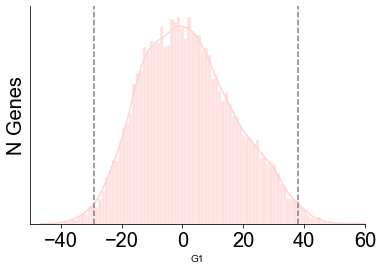

In [92]:
import seaborn as sns
from matplotlib import font_manager
font_manager.fontManager.addfont("/n02dat01/users/lchai/anaconda3/envs/Nm/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/arial.ttf")
plt.rcParams["font.sans-serif"] = "Arial" 

# palette = sns.color_palette("Paired")
palette = ['#FFD3D4', '#C0CFFE', '#D6FED3']
for gg in range(3):
    z1  = np.loadtxt(f'{gene_father}/Z1_G{gg+1}.txt')
    print(gg+1, z1[150], z1[-150])
    if gg ==0: df = pd.DataFrame({'G1':z1})
    else: df[f'G{gg+1}'] = z1

# Create histogram with custom settings
gg=0
# plt.figure(figsize=(25, 10), dpi=500)
sns.histplot(data=df, x=f'G{gg+1}', bins=100, kde=True,
            color=palette[gg], alpha=0.7, edgecolor="white")
sns.despine(top=True, right=True)

if gg ==0:
    plt.axvline(x=38, color='grey', linestyle='dashed')
    plt.axvline(x=-29, color='grey', linestyle='dashed')
if gg ==1:
    plt.axvline(x=11, color='grey', linestyle='dashed')
    plt.axvline(x=-14, color='grey', linestyle='dashed')
if gg ==2:
    plt.axvline(x=32, color='grey', linestyle='dashed')
    plt.axvline(x=-28, color='grey', linestyle='dashed')

plt.xlim(-50, 60)
plt.ylabel('N Genes', fontsize=20)
plt.yticks([])
plt.xticks(fontsize=20)
# plt.xlabel(f'CG{gg+1}-DV', fontsize=20)
plt.savefig(f'/n02dat01/users/dyli/Grad_code/gene_z_G{gg+1}.png', transparent = True, bbox_inches = 'tight',dpi = 700)
plt.show

1 38.43543 -29.343176
5992


<function matplotlib.pyplot.show(close=None, block=None)>

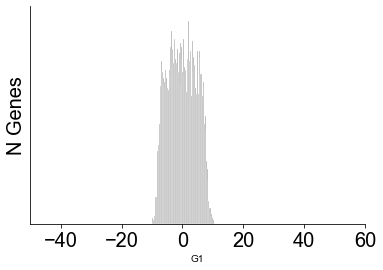

In [99]:
import seaborn as sns
from matplotlib import font_manager
font_manager.fontManager.addfont("/n02dat01/users/lchai/anaconda3/envs/Nm/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/arial.ttf")
plt.rcParams["font.sans-serif"] = "Arial" 

# palette = sns.color_palette("Paired")
palette = ['#FFD3D4', '#C0CFFE', '#D6FED3']
gg=0

z1  = np.loadtxt(f'{gene_father}/Z1_G{gg+1}.txt')
fwe = np.loadtxt(f'{gene_father}/p1_G{gg+1}fwe.txt')
print(gg+1, z1[150], z1[-150])
ind_GC = list(np.squeeze(ind1[np.argwhere(np.abs(z1)<7)]).astype(np.int32))
print(len(ind_GC))
ind_GC = np.array(ind_GC)
z1_grey = np.array([z1[int(ind_GC[i])] for i in range(ind_GC.shape[0])])
df_grey = pd.DataFrame({f'G{gg+1}':z1_grey})

# Create histogram with custom settings
# plt.figure(figsize=(25, 10), dpi=500)
sns.histplot(data=df_grey, x=f'G{gg+1}', bins=100, # kde=True,
            color='grey', alpha=0.7, edgecolor="white")
sns.despine(top=True, right=True)

plt.xlim(-50, 60)
plt.ylabel('N Genes', fontsize=20)
plt.yticks([])
plt.xticks(fontsize=20)
# plt.xlabel(f'CG{gg+1}-DV', fontsize=20)
plt.savefig(f'/n02dat01/users/dyli/Grad_code/gene_z_G{gg+1}_grey.png', transparent = True, bbox_inches = 'tight',dpi = 700)
plt.show

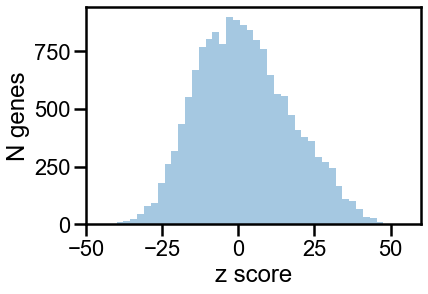

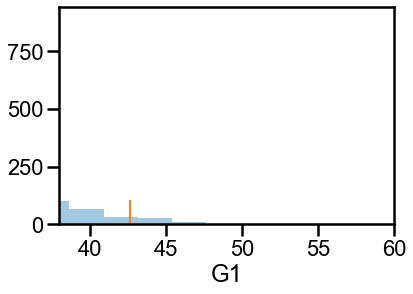

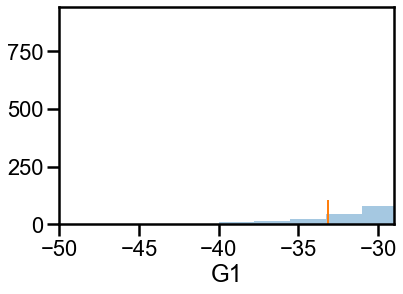

In [126]:
gg=0
## WHOLE DISTRIBUTION
plt.close()
sns.set_context('poster',font_scale=1)
sns.distplot(df[f'G{gg+1}'],kde=False)
plt.xlim(-50,60)
plt.xlabel('z score')
plt.ylabel('N genes')
# plt.savefig(os.path.join(fig_dir,'BetaDist.png'),
#           bbox_inches = 'tight')
plt.show()

## ZOOM ON RIGHT SIDE
plt.close()
sns.set_context('poster',font_scale=1)
sns.distplot(df[f'G{gg+1}'],kde=False)
plt.xlim(38,60)
# plt.ylim(0,50)
xval = sorted(df[f'G{gg+1}'])[-50]
plt.plot([xval, xval], [0, 100], linewidth=2)
# plt.savefig(os.path.join(fig_dir,'BetaDistL.png'),
#           bbox_inches='tight')
plt.show()

# ZOOM ON LEFT SIDE
plt.close()
sns.set_context('poster',font_scale=1)
sns.distplot(df[f'G{gg+1}'],kde=False)
plt.xlim(-50,-29)
# plt.xticks([-0.02, 0, -0.01, -0.005])
# plt.ylim(0,5)
xval = sorted(df[f'G{gg+1}'])[50]
plt.plot([xval, xval], [0, 100], linewidth=2)
# plt.savefig(os.path.join(fig_dir,'BetaDistR.png'),
#           bbox_inches='tight')
plt.show()

<function matplotlib.pyplot.show(close=None, block=None)>

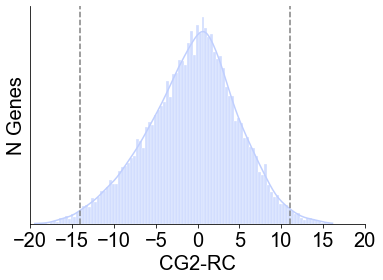

In [95]:
# Create histogram with custom settings
gg=1
# plt.figure(figsize=(25, 10), dpi=500)
sns.histplot(data=df, x=f'G{gg+1}', bins=100, kde=True,
            color=palette[gg], alpha=0.7, edgecolor="white")
sns.despine(top=True, right=True)
if gg ==0:
    plt.axvline(x=38, color='grey', linestyle='dashed')
    plt.axvline(x=-29, color='grey', linestyle='dashed')
if gg ==1:
    plt.axvline(x=11, color='grey', linestyle='dashed')
    plt.axvline(x=-14, color='grey', linestyle='dashed')
if gg ==2:
    plt.axvline(x=32, color='grey', linestyle='dashed')
    plt.axvline(x=-28, color='grey', linestyle='dashed')

plt.xlim(-20, 20)
plt.ylabel('N Genes', fontsize=20)
plt.yticks([])
plt.xticks(fontsize=20)
plt.xlabel(f'CG{gg+1}-RC', fontsize=20)
plt.savefig(f'/n02dat01/users/dyli/Grad_code/gene_z_G{gg+1}.png', transparent = True, bbox_inches = 'tight',dpi = 700)
plt.show

2 11.261249 -13.984301
12506


<function matplotlib.pyplot.show(close=None, block=None)>

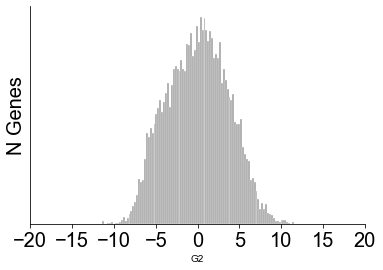

In [100]:
import seaborn as sns
from matplotlib import font_manager
font_manager.fontManager.addfont("/n02dat01/users/lchai/anaconda3/envs/Nm/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/arial.ttf")
plt.rcParams["font.sans-serif"] = "Arial" 

# palette = sns.color_palette("Paired")
palette = ['#FFD3D4', '#C0CFFE', '#D6FED3']
gg=1

z1  = np.loadtxt(f'{gene_father}/Z1_G{gg+1}.txt')
fwe = np.loadtxt(f'{gene_father}/p1_G{gg+1}fwe.txt')
print(gg+1, z1[150], z1[-150])
ind_GC = list(np.squeeze(ind1[np.argwhere(np.abs(z1)<7)]).astype(np.int32))
print(len(ind_GC))
ind_GC = np.array(ind_GC)
z1_grey = np.array([z1[int(ind_GC[i])] for i in range(ind_GC.shape[0])])
df_grey = pd.DataFrame({f'G{gg+1}':z1_grey})

# Create histogram with custom settings
# plt.figure(figsize=(25, 10), dpi=500)
sns.histplot(data=df_grey, x=f'G{gg+1}', bins=100, # kde=True,
            color='grey', alpha=0.7, edgecolor="white")
sns.despine(top=True, right=True)

plt.xlim(-20, 20)
plt.ylabel('N Genes', fontsize=20)
plt.yticks([])
plt.xticks(fontsize=20)
# plt.xlabel(f'CG{gg+1}-DV', fontsize=20)
plt.savefig(f'/n02dat01/users/dyli/Grad_code/gene_z_G{gg+1}_grey.png', transparent = True, bbox_inches = 'tight',dpi = 700)
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

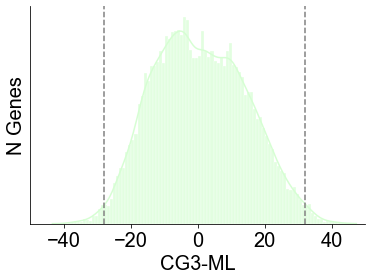

In [96]:
# Create histogram with custom settings
gg=2
# plt.figure(figsize=(25, 10), dpi=500)
sns.histplot(data=df, x=f'G{gg+1}', bins=100, kde=True,
            color=palette[gg], alpha=0.7, edgecolor="white")
sns.despine(top=True, right=True)
if gg ==0:
    plt.axvline(x=38, color='grey', linestyle='dashed')
    plt.axvline(x=-29, color='grey', linestyle='dashed')
if gg ==1:
    plt.axvline(x=11, color='grey', linestyle='dashed')
    plt.axvline(x=-14, color='grey', linestyle='dashed')
if gg ==2:
    plt.axvline(x=32, color='grey', linestyle='dashed')
    plt.axvline(x=-28, color='grey', linestyle='dashed')

plt.xlim(-50, 50)
plt.ylabel('N Genes', fontsize=20)
plt.yticks([])
plt.xticks(fontsize=20)
plt.xlabel(f'CG{gg+1}-ML', fontsize=20)
plt.savefig(f'/n02dat01/users/dyli/Grad_code/gene_z_G{gg+1}.png', transparent = True, bbox_inches = 'tight',dpi = 700)
plt.show

3 32.078457 -27.53383
4571


<function matplotlib.pyplot.show(close=None, block=None)>

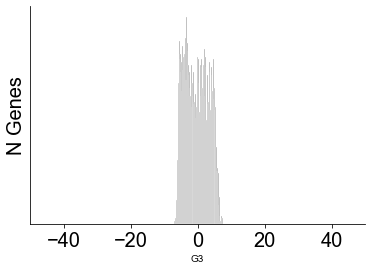

In [97]:
import seaborn as sns
from matplotlib import font_manager
font_manager.fontManager.addfont("/n02dat01/users/lchai/anaconda3/envs/Nm/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/arial.ttf")
plt.rcParams["font.sans-serif"] = "Arial" 

# palette = sns.color_palette("Paired")
palette = ['#FFD3D4', '#C0CFFE', '#D6FED3']
gg=2

z1  = np.loadtxt(f'{gene_father}/Z1_G{gg+1}.txt')
fwe = np.loadtxt(f'{gene_father}/p1_G{gg+1}fwe.txt')
print(gg+1, z1[150], z1[-150])
ind_GC = list(np.squeeze(ind1[np.argwhere(np.abs(z1)<6)]).astype(np.int32))
print(len(ind_GC))
ind_GC = np.array(ind_GC)
z1_grey = np.array([z1[int(ind_GC[i])] for i in range(ind_GC.shape[0])])
df_grey = pd.DataFrame({f'G{gg+1}':z1_grey})

# Create histogram with custom settings
# plt.figure(figsize=(25, 10), dpi=500)
sns.histplot(data=df_grey, x=f'G{gg+1}', bins=100, # kde=True,
            color='grey', alpha=0.7, edgecolor="white")
sns.despine(top=True, right=True)

plt.xlim(-50, 50)
plt.ylabel('N Genes', fontsize=20)
plt.yticks([])
plt.xticks(fontsize=20)
# plt.xlabel(f'CG{gg+1}-DV', fontsize=20)
plt.savefig(f'/n02dat01/users/dyli/Grad_code/gene_z_G{gg+1}_grey.png', transparent = True, bbox_inches = 'tight',dpi = 700)
plt.show

In [8]:
# read the gene name
gene_name_path = '/n02dat01/users/dyli/Grad_data/support_data/gene_name.txt'
with open( gene_name_path, 'r' ) as f:
    gene_namelist = [ str( line.strip()) for line in f.readlines() ]
assert len(gene_namelist) == 15633

gene_name_path = './GO_analysis/a.txt'
with open( gene_name_path, 'r' ) as f:
    a = [ str( line.strip()) for line in f.readlines() ]

gene_name_path = './GO_analysis/c.txt'
with open( gene_name_path, 'r' ) as f:
    c = [ str( line.strip()) for line in f.readlines() ]
    
gene_name_path = './GO_analysis/n.txt'
with open( gene_name_path, 'r' ) as f:
    n = [ str( line.strip()) for line in f.readlines() ]

gene_name_path = './GO_analysis/p.txt'
with open( gene_name_path, 'r' ) as f:
    p = [ str( line.strip()) for line in f.readlines() ]
    
# gene_name_path = './GO_analysis/r.txt'
# with open( gene_name_path, 'r' ) as f:
#     r = [ str( line.strip()) for line in f.readlines() ]

_ = list(set(gene_save_list).intersection(set(a)))
print(len(_), len(a))

_ = list(set(gene_save_list).intersection(set(c)))
print(len(_), len(c))

_ = list(set(gene_save_list).intersection(set(n)))
print(len(_), len(n))

_ = list(set(gene_save_list).intersection(set(p)))
print(len(_), len(p))

e = list(set(a).union(set(c)))
print(len(e))
e = list(set(e).union(set(n)))
print(len(e))
e = list(set(e).union(set(p)))
print(len(e))



ind_all_pnas = []
for gg in range(3):
    print(f'the results of global connectopy GC{gg+1}:')
    ind1= np.loadtxt(f'{gene_father}/ind1_G{gg+1}.txt')
    z1  = np.loadtxt(f'{gene_father}/Z1_G{gg+1}.txt')
    z2  = np.loadtxt(f'{gene_father}/Z2_G{gg+1}.txt')
    p1  = np.loadtxt(f'{gene_father}/p1_G{gg+1}.txt')
    p2  = np.loadtxt(f'{gene_father}/p2_G{gg+1}.txt')
    fwe = np.loadtxt(f'{gene_father}/p1_G{gg+1}fwe.txt')
    # print(f'PNAS: {len(np.argwhere(z1>z_thr))+len(np.argwhere(z1<-1*z_thr))}')
    print(f'PNAS: {len(np.argwhere(fwe==0))}')
    ind_GC = list(np.squeeze(ind1[np.argwhere(fwe==0)]).astype(np.int32))

    gene_save_list = [gene_namelist[int(ind_GC[ii]-1)] for ii in range(len(ind_GC))]
    gene_exp_array = np.zeros((2, len(gene_save_list)))
    for gene_i, gene in enumerate(gene_save_list):
        gene_exp_array[:, gene_i] = np.array([1,2])
    gene_exp_df = pd.DataFrame(gene_exp_array, columns=gene_save_list, index = [1,2])

    # choose PNAS results
    ind_temp = list(np.squeeze(ind1[np.argwhere(fwe==0)]).astype(np.int32))
    # ind_temp = list(np.squeeze(ind1[np.argwhere(np.abs(z1)>9)]).astype(np.int32))
    if len(ind_all_pnas) ==0: ind_all_pnas = ind_temp
    else: ind_all_pnas = list(set(ind_all_pnas).intersection(set(ind_temp)))
print(len(ind_all_pnas))
pnas_list = [gene_namelist[int(ind_all_pnas[ii]-1)] for ii in range(len(ind_all_pnas))]
print(len(list(set(pnas_list).intersection(set(e)))))

err = list(set(pnas_list).union(set(e)))
print(len(err))
gene_exp_df = pd.DataFrame([], columns=err)
# gene_exp_df.to_csv(f'/n02dat01/users/dyli/Grad_data/gene_plsr/ThreeGC_all_sample1.csv')

212 212
168 168
166 166
43 43
319
352
352
the results of global connectopy GC1:
PNAS: 9421
the results of global connectopy GC2:
PNAS: 2041
the results of global connectopy GC3:
PNAS: 9341
1863
352
1863


In [29]:
exp_name = 'sample3466'
gene_father = f'/n02dat01/users/dyli/Grad_data/support_data/Gene_results/{exp_name}'

expression = pd.read_csv('/n02dat01/users/dyli/Grad_data/support_data/allen_expression_3466.csv')

# read the basic info
dirc_L = '/n02dat01/users/dyli/Atlas/metric_index_L.txt'
select_ind_L = np.loadtxt( dirc_L ).astype(int)
dirc_R = '/n02dat01/users/dyli/Atlas/metric_index_R.txt'
select_ind_R = np.loadtxt( dirc_R ).astype(int)

# read the gene name
gene_namelist = expression.columns[1:]
assert len(gene_namelist) == 15633

z_thr = 5
for gene_num in range(100,510,10):

    ind_all_pos = []
    ind_all_neg = []
    ind_all_all = []
    ind_all_my = []
    for gg in range(3):
        # print(f'the results of global connectopy GC{gg+1}:')
        ind1= np.loadtxt(f'{gene_father}/ind1_G{gg+1}.txt')
        z1  = np.loadtxt(f'{gene_father}/Z1_G{gg+1}.txt')
        z2  = np.loadtxt(f'{gene_father}/Z2_G{gg+1}.txt')
        p1  = np.loadtxt(f'{gene_father}/p1_G{gg+1}.txt')
        p2  = np.loadtxt(f'{gene_father}/p2_G{gg+1}.txt')
        fwe = np.loadtxt(f'{gene_father}/p1_G{gg+1}fwe.txt')
        ind_GC_pos = list(ind1[0:gene_num])
        ind_GC_neg = list(ind1[-1*gene_num:])
        assert len(ind_GC_pos) == gene_num
        assert len(ind_GC_neg) == gene_num

        gene_save_list = [gene_namelist[int(ind_GC_pos[ii]-1)] for ii in range(len(ind_GC_pos))]
        gene_exp_df = pd.DataFrame([], columns=gene_save_list)
        gene_exp_df.to_csv(f'/n02dat01/users/dyli/Grad_data/gene_plsr/GC{gg+1}_{gene_num}_pos_sample.csv')

        gene_save_list = [gene_namelist[int(ind_GC_neg[ii]-1)] for ii in range(len(ind_GC_neg))]
        gene_exp_df = pd.DataFrame([], columns=gene_save_list)
        gene_exp_df.to_csv(f'/n02dat01/users/dyli/Grad_data/gene_plsr/GC{gg+1}_{gene_num}_neg_sample.csv')

        ind_GC_all = ind_GC_pos + ind_GC_neg
        gene_save_list = [gene_namelist[int(ind_GC_all[ii]-1)] for ii in range(len(ind_GC_all))]
        gene_exp_df = pd.DataFrame([], columns=gene_save_list)
        gene_exp_df.to_csv(f'/n02dat01/users/dyli/Grad_data/gene_plsr/GC{gg+1}_{gene_num}_all_sample.csv')

        # choose PNAS results
        ind_temp = ind_GC_pos
        if len(ind_all_pos) ==0: ind_all_pos = ind_temp
        else: ind_all_pos = list(set(ind_all_pos).intersection(set(ind_temp)))

        ind_temp = ind_GC_neg
        if len(ind_all_neg) ==0: ind_all_neg = ind_temp
        else: ind_all_neg = list(set(ind_all_neg).intersection(set(ind_temp)))

        ind_temp = ind_GC_pos + ind_GC_neg
        if len(ind_all_all) ==0: ind_all_all = ind_temp
        else: ind_all_all = list(set(ind_all_all).intersection(set(ind_temp)))

    print(f'{gene_num*2} ({gene_num/15633*100}%): pos: {len(ind_GC_pos)} neg: {len(ind_GC_neg)} all: {len(ind_all_all)}')

    gene_save_list = [gene_namelist[int(ind_all_pos[ii]-1)] for ii in range(len(ind_all_pos))]
    gene_exp_df = pd.DataFrame([], columns=gene_save_list)
    gene_exp_df.to_csv(f'/n02dat01/users/dyli/Grad_data/gene_plsr/ThreeGC_{gene_num}_pos_sample.csv')

    gene_save_list = [gene_namelist[int(ind_all_neg[ii]-1)] for ii in range(len(ind_all_neg))]
    gene_exp_df = pd.DataFrame([], columns=gene_save_list)
    gene_exp_df.to_csv(f'/n02dat01/users/dyli/Grad_data/gene_plsr/ThreeGC_{gene_num}_neg_sample.csv')

    gene_save_list = [gene_namelist[int(ind_all_all[ii]-1)] for ii in range(len(ind_all_all))]
    gene_exp_df = pd.DataFrame([], columns=gene_save_list)
    gene_exp_df.to_csv(f'/n02dat01/users/dyli/Grad_data/gene_plsr/ThreeGC_{gene_num}_all_sample.csv')

200 (0.6396724876863046%): pos: 100 neg: 100 all: 7
220 (0.703639736454935%): pos: 110 neg: 110 all: 11
240 (0.7676069852235655%): pos: 120 neg: 120 all: 16
260 (0.831574233992196%): pos: 130 neg: 130 all: 22
280 (0.8955414827608265%): pos: 140 neg: 140 all: 27
300 (0.9595087315294568%): pos: 150 neg: 150 all: 34
320 (1.0234759802980875%): pos: 160 neg: 160 all: 38
340 (1.0874432290667178%): pos: 170 neg: 170 all: 43
360 (1.1514104778353482%): pos: 180 neg: 180 all: 52
380 (1.215377726603979%): pos: 190 neg: 190 all: 60
400 (1.2793449753726092%): pos: 200 neg: 200 all: 69
420 (1.3433122241412399%): pos: 210 neg: 210 all: 76
440 (1.40727947290987%): pos: 220 neg: 220 all: 81
460 (1.4712467216785006%): pos: 230 neg: 230 all: 86
480 (1.535213970447131%): pos: 240 neg: 240 all: 93
500 (1.5991812192157613%): pos: 250 neg: 250 all: 101
520 (1.663148467984392%): pos: 260 neg: 260 all: 108
540 (1.7271157167530224%): pos: 270 neg: 270 all: 114


In [10]:
exp_name = 'sample3466'
gene_father = f'/n02dat01/users/dyli/Grad_data/support_data/Gene_results/{exp_name}'

expression = pd.read_csv('/n02dat01/users/dyli/Grad_data/support_data/allen_expression_3466.csv')

# read the basic info
dirc_L = '/n02dat01/users/dyli/Atlas/metric_index_L.txt'
select_ind_L = np.loadtxt( dirc_L ).astype(int)
dirc_R = '/n02dat01/users/dyli/Atlas/metric_index_R.txt'
select_ind_R = np.loadtxt( dirc_R ).astype(int)

# read the gene name
gene_namelist = expression.columns[1:]
assert len(gene_namelist) == 15633

z_thr = 5
for gene_num in [130,150]:

    ind_all_pos = []
    ind_all_neg = []
    ind_all_all = []
    ind_all_my = []
    
    # print(f'the results of global connectopy GC{gg+1}:')
    gg=0
    G1_ind1= np.loadtxt(f'{gene_father}/ind1_G{gg+1}.txt')
    G1_z1  = np.loadtxt(f'{gene_father}/Z1_G{gg+1}.txt')
    G1_z2  = np.loadtxt(f'{gene_father}/Z2_G{gg+1}.txt')
    G1_p1  = np.loadtxt(f'{gene_father}/p1_G{gg+1}.txt')
    G1_p2  = np.loadtxt(f'{gene_father}/p2_G{gg+1}.txt')
    G1_fwe = np.loadtxt(f'{gene_father}/p1_G{gg+1}fwe.txt')
    G1_ind_GC_pos = list(G1_ind1[0:gene_num])
    G1_ind_GC_neg = list(G1_ind1[-1*gene_num:])
    G1_ind_GC_all = G1_ind_GC_pos + G1_ind_GC_neg
    G1_gene_save_list = [gene_namelist[int(G1_ind_GC_all[ii]-1)] for ii in range(len(G1_ind_GC_all))]
    
    gg=1
    G2_ind1= np.loadtxt(f'{gene_father}/ind1_G{gg+1}.txt')
    G2_z1  = np.loadtxt(f'{gene_father}/Z1_G{gg+1}.txt')
    G2_z2  = np.loadtxt(f'{gene_father}/Z2_G{gg+1}.txt')
    G2_p1  = np.loadtxt(f'{gene_father}/p1_G{gg+1}.txt')
    G2_p2  = np.loadtxt(f'{gene_father}/p2_G{gg+1}.txt')
    G2_fwe = np.loadtxt(f'{gene_father}/p1_G{gg+1}fwe.txt')
    G2_ind_GC_pos = list(G2_ind1[0:gene_num])
    G2_ind_GC_neg = list(G2_ind1[-1*gene_num:])
    G2_ind_GC_all = G2_ind_GC_pos + G2_ind_GC_neg
    G3_gene_save_list = [gene_namelist[int(G2_ind_GC_all[ii]-1)] for ii in range(len(G2_ind_GC_all))]
    
    gg=2
    G3_ind1= np.loadtxt(f'{gene_father}/ind1_G{gg+1}.txt')
    G3_z1  = np.loadtxt(f'{gene_father}/Z1_G{gg+1}.txt')
    G3_z2  = np.loadtxt(f'{gene_father}/Z2_G{gg+1}.txt')
    G3_p1  = np.loadtxt(f'{gene_father}/p1_G{gg+1}.txt')
    G3_p2  = np.loadtxt(f'{gene_father}/p2_G{gg+1}.txt')
    G3_fwe = np.loadtxt(f'{gene_father}/p1_G{gg+1}fwe.txt')
    G3_ind_GC_pos = list(G3_ind1[0:gene_num])
    G3_ind_GC_neg = list(G3_ind1[-1*gene_num:])
    G3_ind_GC_all = G3_ind_GC_pos + G3_ind_GC_neg
    G3_gene_save_list = [gene_namelist[int(G3_ind_GC_all[ii]-1)] for ii in range(len(G3_ind_GC_all))]
    
    # G1 G2
    G12_ind_GC_all = list(set(G1_ind_GC_all).intersection(set(G2_ind_GC_all)))
    # G1 G3
    G13_ind_GC_all = list(set(G1_ind_GC_all).intersection(set(G3_ind_GC_all)))
    # G1 G2
    G23_ind_GC_all = list(set(G2_ind_GC_all).intersection(set(G3_ind_GC_all)))
    
    print(gene_num, len(G1_ind_GC_all), len(G2_ind_GC_all), len(G3_ind_GC_all), 
          len(G12_ind_GC_all), len(G13_ind_GC_all), len(G23_ind_GC_all))
    

130 260 260 260 68 51 76
150 300 300 300 87 71 97


# bar

In [2]:
data = pd.read_csv('/n02dat01/users/dyli/Grad_data/ThreeGC_BP.xlsx')
data

UnicodeDecodeError: 'utf-8' codec can't decode bytes in position 15-16: invalid continuation byte

In [5]:
exp_name = 'sample3466'
gene_father = f'/n02dat01/users/dyli/Grad_data/support_data/Gene_results/{exp_name}'

expression = pd.read_csv('/n02dat01/users/dyli/Grad_data/support_data/allen_expression_3466.csv')

# read the basic info
dirc_L = '/n02dat01/users/dyli/Atlas/metric_index_L.txt'
select_ind_L = np.loadtxt( dirc_L ).astype(int)
dirc_R = '/n02dat01/users/dyli/Atlas/metric_index_R.txt'
select_ind_R = np.loadtxt( dirc_R ).astype(int)

# read the gene name
gene_namelist = expression.columns[1:]
assert len(gene_namelist) == 15633

z_thr = 5
for gene_num in [130]:

    ind_all_pos = []
    ind_all_neg = []
    ind_all_all = []
    ind_all_my = []
    
    # print(f'the results of global connectopy GC{gg+1}:')
    gg=0
    G1_ind1= np.loadtxt(f'{gene_father}/ind1_G{gg+1}.txt')
    G1_z1  = np.loadtxt(f'{gene_father}/Z1_G{gg+1}.txt')
    G1_z2  = np.loadtxt(f'{gene_father}/Z2_G{gg+1}.txt')
    G1_p1  = np.loadtxt(f'{gene_father}/p1_G{gg+1}.txt')
    G1_p2  = np.loadtxt(f'{gene_father}/p2_G{gg+1}.txt')
    G1_fwe = np.loadtxt(f'{gene_father}/p1_G{gg+1}fwe.txt')
    G1_ind_GC_pos = list(G1_ind1[0:gene_num])
    G1_ind_GC_neg = list(G1_ind1[-1*gene_num:])
    G1_ind_GC_all = G1_ind_GC_pos + G1_ind_GC_neg
    G1_gene_save_list = [gene_namelist[int(G1_ind_GC_all[ii]-1)] for ii in range(len(G1_ind_GC_all))]
    
    gg=1
    G2_ind1= np.loadtxt(f'{gene_father}/ind1_G{gg+1}.txt')
    G2_z1  = np.loadtxt(f'{gene_father}/Z1_G{gg+1}.txt')
    G2_z2  = np.loadtxt(f'{gene_father}/Z2_G{gg+1}.txt')
    G2_p1  = np.loadtxt(f'{gene_father}/p1_G{gg+1}.txt')
    G2_p2  = np.loadtxt(f'{gene_father}/p2_G{gg+1}.txt')
    G2_fwe = np.loadtxt(f'{gene_father}/p1_G{gg+1}fwe.txt')
    G2_ind_GC_pos = list(G2_ind1[0:gene_num])
    G2_ind_GC_neg = list(G2_ind1[-1*gene_num:])
    G2_ind_GC_all = G2_ind_GC_pos + G2_ind_GC_neg
    G3_gene_save_list = [gene_namelist[int(G2_ind_GC_all[ii]-1)] for ii in range(len(G2_ind_GC_all))]
    
    gg=2
    G3_ind1= np.loadtxt(f'{gene_father}/ind1_G{gg+1}.txt')
    G3_z1  = np.loadtxt(f'{gene_father}/Z1_G{gg+1}.txt')
    G3_z2  = np.loadtxt(f'{gene_father}/Z2_G{gg+1}.txt')
    G3_p1  = np.loadtxt(f'{gene_father}/p1_G{gg+1}.txt')
    G3_p2  = np.loadtxt(f'{gene_father}/p2_G{gg+1}.txt')
    G3_fwe = np.loadtxt(f'{gene_father}/p1_G{gg+1}fwe.txt')
    G3_ind_GC_pos = list(G3_ind1[0:gene_num])
    G3_ind_GC_neg = list(G3_ind1[-1*gene_num:])
    G3_ind_GC_all = G3_ind_GC_pos + G3_ind_GC_neg
    G3_gene_save_list = [gene_namelist[int(G3_ind_GC_all[ii]-1)] for ii in range(len(G3_ind_GC_all))]
    
    # G1 G2
    G12_ind_GC_all = list(set(G1_ind_GC_all).intersection(set(G2_ind_GC_all)))
    # G1 G3
    G13_ind_GC_all = list(set(G1_ind_GC_all).intersection(set(G3_ind_GC_all)))
    # G1 G2
    G23_ind_GC_all = list(set(G2_ind_GC_all).intersection(set(G3_ind_GC_all)))
    
    print(gene_num, len(G1_ind_GC_all), len(G2_ind_GC_all), len(G3_ind_GC_all), 
          len(G12_ind_GC_all), len(G13_ind_GC_all), len(G23_ind_GC_all))
    

130 260 260 260 68 51 76


In [4]:
gene30_list = ['BMP2', 'BMP2K', 'BMP6', 'BMP7', 
            'EMX2', 
            'EPHA7', 
            'ETV1', 
            'FGF17', 
            'FGF8', 
            'FGFR3', 
            'FOXG1', 
            'ID2', 
            'LHX2', 
            'LMO3', 
            'LMO4', 
            'PAX6', 
            'RORB', 
            'SFRP1', 'SFRP2', 
            'SP5', 
            'SPRY1', 
            'TBR1', 
            'WNT3', 'WNT2B', 'WNT5A']

In [6]:
i=0
for _gene in gene30_list:
    if _gene in G1_ind_GC_all or _gene in G2_ind_GC_all or _gene in G3_ind_GC_all: i+=1
print(i, i/len(gene30_list))

0 0.0
